<a href="https://colab.research.google.com/github/androbaza/image-processing-matlab/blob/main/Canny_Edge_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/androbaza/standard-test-images.git
from scipy.ndimage import gaussian_filter
from scipy import signal, misc
from skimage.color import rgb2grey
from skimage import feature
import matplotlib.image as mpim
import matplotlib.pyplot as plt
import numpy as np

Scharr edge detection operator provides better result than Sobel kernel

In [14]:
def scharr(image):
  kernel = np.array([[47, 0, -47], [162, 0, -162], [47, 0, -47]])

  convX, convY = signal.convolve(image, kernel, mode='same'), signal.convolve(image, kernel.T, mode='same')

  G = np.sqrt(np.square(convX) + np.square(convY))
  G *= 255 / G.max()

  Th = np.arctan2(convX, convY)

  return G, np.degrees(Th)

Non-maximum suppression - edge thinning according to the change of intensity value. The neighbourhood is divided into 8 parts by 45 degrees.

In [10]:
def NMsup (G, Th):
  h, w = G.shape
  suppressed_image = np.zeros(G.shape)

  for y in range(1, h-1):
    for x in range(1, w-1):
      if (Th[y,x] > 22.5 and Th[y,x] < 67.5) or (Th[y,x] > -157.5 and Th[y,x] < -112.5):
        if (G[y,x] <= G[y-1,x-1]) or (G[y,x] <= G[y+1,x+1]):
          suppressed_image[y,x] = 0
        else:
          suppressed_image[y,x] = G[y,x]
          
      elif (Th[y,x] >= -22.5 and Th[y,x] <= 22.5) or (Th[y,x] >= 157.5 and Th[y,x] <= -157.5):
        if (G[y,x] <= G[y-1,x]) or (G[y,x] <= G[y+1,x]):
          suppressed_image[y,x] = 0
        else:
          suppressed_image[y,x] = G[y,x]
      
      elif (Th[y,x] >= 67.5 and Th[y,x] <= 112.5) or (Th[y,x] >= -112.5 and Th[y,x] <= -67.5):
        if (G[y,x] <= G[y,x-1]) or (G[y,x] <= G[y,x+1]):
          suppressed_image[y,x] = 0
        else:
          suppressed_image[y,x] = G[y,x]

      elif (Th[y,x] > 112.5 and Th[y,x] < 157.5) or (Th[y,x] > -67.5 and Th[y,x] < -22.5):
        if (G[y,x] <= G[y-1,x+1]) or (G[y,x] <= G[y+1,x-1]):
          suppressed_image[y,x] = 0
        else:
          suppressed_image[y,x] = G[y,x]

  return suppressed_image

Threshold the values to cut noise. Values between low and high thresholds are "weak" and require further processing.

In [5]:
def cut_low (image, threshold_low, threshold_high):
  h, w = image.shape

  for y in range(0, h-1):
    for x in range(0, w-1):
      if image[y,x] >= threshold_high:
        image[y,x] = 255
      elif image[y,x] < threshold_high and image[y,x] > threshold_low:
        image[y,x] = 128
      elif image[y,x] <= threshold_low:
        image[y,x] = 0
        
  return image

The "weak" pixels are either converted to strong or discarded according to presense of strong pixels in the 8-neighbourhood.

In [6]:
def connect_lines (image):
  h, w = image.shape

  for y in range(1, h-1):
    for x in range(1, w-1):
      if image[y,x] == 128:
        if image[y+1,x] == 255 or image[y+1,x+1] == 255 or image[y+1,x-1] == 255 or image[y-1,x] == 255 or image[y-1,x-1] == 255 or image[y-1,x+1] == 255 or image[y,x+1] == 255 or image[y,x-1] == 255:
          image[y,x] = 255
        else:
          image[y,x] = 0
  return image

Canny edge function to call all previous functions in order. If there are no thresholds provided, they are 10% adn 20% of max value respectively.

In [7]:
def canny_edge (image, sigma, threshold_low = '', threshold_high = ''):
  image = gaussian_filter(image, sigma = sigma)
  G, Th = scharr(image)
  suppressed_image = NMsup(G, Th)

  if threshold_low == '':
    threshold_low = 0.1*suppressed_image.max()
  if threshold_high == '':
    threshold_high = 0.2*suppressed_image.max()

  thresholded_image = cut_low(suppressed_image, threshold_low = threshold_low, threshold_high = threshold_high)
  result = connect_lines(thresholded_image)
  return result

Driver code to compare the performance on "Lena".

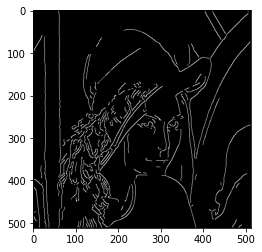

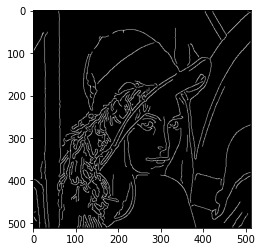

In [19]:
image = mpim.imread('/content/standard-test-images/lena_color_512.tif')
image = rgb2grey(image)
my_result = canny_edge(image, 2)
skimage_result = feature.canny(image, 2)
plt.figure()
plt.imshow(my_result, cmap='gray')
plt.figure()
plt.imshow(skimage_result, cmap='gray')